<a href="https://colab.research.google.com/github/heysourin/NLP-101/blob/main/LSTM/LSTM_IMDB_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [1]:
# Configuring the kaggle.json file, that I have uploaded to colab files.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 54% 14.0M/25.7M [00:00<00:00, 140MB/s]
100% 25.7M/25.7M [00:00<00:00, 181MB/s]


In [3]:
from zipfile import ZipFile
dataset = '/content/imdb-dataset-of-50k-movie-reviews.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Data, extracted!")

Data, extracted!


In [4]:
import os
import json

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Loading dataset:

In [5]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [6]:
df.shape

(50000, 2)

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Checking if imbalance exists in data:


In [11]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Converting to numerical values:

In [12]:
df.replace({"sentiment":{"positive":1, "negative":0}}, inplace=True)

In [13]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## **Train test split:**

In [14]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
train_data.shape, test_data.shape

((40000, 2), (10000, 2))

In [16]:
train_data.head()

,review,sentiment
39087,That's what I kept asking myself during the ma...,0
30893,I did not watch the entire movie. I could not ...,0
45278,A touching love story reminiscent of In the M...,1
16398,This latter-day Fulci schlocker is a totally a...,0
13653,"First of all, I firmly believe that Norwegian ...",0


## **Data preprocessing:**

### 1. Tokenizing:

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [18]:
y_train = train_data["sentiment"]
y_test = test_data["sentiment"]

## **LSTM:**

In [25]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.3))
model.add(Dense(1, activation="sigmoid"))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 [==============================] - 386s 767ms/step - loss: 0.4187 - accuracy: 0.8054 - val_loss: 0.3175 - val_accuracy: 0.8711
Epoch 2/5
500/500 [==============================] - 383s 766ms/step - loss: 0.2788 - accuracy: 0.8904 - val_loss: 0.2939 - val_accuracy: 0.8760
Epoch 3/5
500/500 [==============================] - 381s 763ms/step - loss: 0.2495 - accuracy: 0.8999 - val_loss: 0.3031 - val_accuracy: 0.8701
Epoch 4/5
500/500 [==============================] - 381s 761ms/step - loss: 0.2116 - accuracy: 0.9184 - val_loss: 0.3290 - val_accuracy: 0.8751
Epoch 5/5
500/500 [==============================] - 381s 761ms/step - loss: 0.1802 - accuracy: 0.9325 - val_loss: 0.3421 - val_accuracy: 0.8705


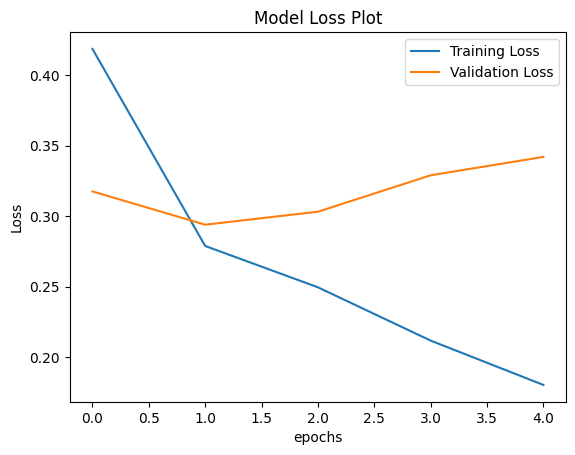

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")

plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('epochs')


plt.legend()

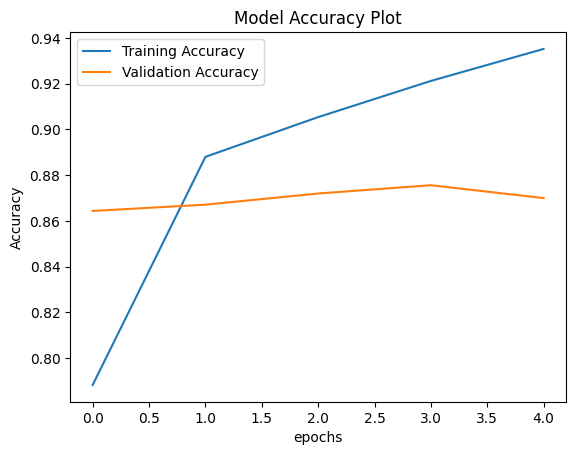

In [24]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")

plt.title('Model Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('epochs')


plt.legend()

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 37s 114ms/step - loss: 0.3186 - accuracy: 0.8799


In [31]:
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Test loss: 0.3185731768608093
Test accuracy: 0.8798999786376953


## **Building a predictive system:**

In [44]:
def predict_sentiment(review)->str:
  # tokenize and pad
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [45]:
new_review = "This movie was outstanding, I love it."

In [46]:
predict_sentiment(new_review)

1/1 [==============================] - 0s 66ms/step


'positive'

In [49]:
predict_sentiment("Very good moive, I loved It")

1/1 [==============================] - 0s 88ms/step


'positive'

In [50]:
predict_sentiment("Moive is not that good")

1/1 [==============================] - 0s 84ms/step


'negative'

In [51]:
tf.__version__

NameError: name 'tf' is not defined